# Read the Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time 
from sklearn.datasets import load_boston
from matplotlib import cm
import seaborn as sns
from scipy.optimize import minimize
import math

In [2]:
columns = ['Exam 1 Score','Exam 2 Score','Result']
dataframe = pd.read_csv("./Data/ex2data1.txt", delimiter=',', header = None, names = columns)
# otterrò una struttura dati chiamata pandas dataframe
# l'indice è fittizio e può essere usato per le queries

# Training/Test set split

In [3]:
#dataframe = dataframe.reindex(['intercept'] + columns, axis="columns") #inserisco la colonna al posto giusto
#preferiamo fare così
dataframe.insert(0,'intercept',1)

In [4]:
shuffled_df = dataframe.sample(frac = 1)

# Separate input X e output Y

In [5]:
#training set
x_train = shuffled_df.iloc[:int(shuffled_df.shape[0]*0.7), :3]
y_train = shuffled_df.iloc[:int(shuffled_df.shape[0]*0.7), [-1]]

#testing set
x_test = shuffled_df.iloc[int(shuffled_df.shape[0]*0.7) :, :3]
y_test = shuffled_df.iloc[int(shuffled_df.shape[0]*0.7) :, [-1]]

In [6]:
# classe negativa
train_neg = x_train[y_train.Result == 0]
# classe positiva
train_pos = x_train[y_train.Result == 1]

# Plot training Data

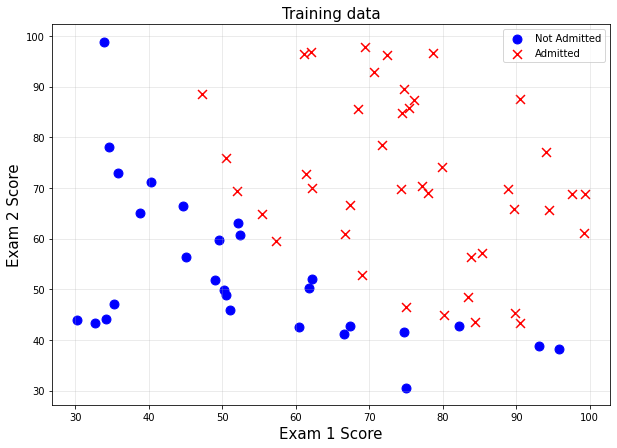

In [7]:
plt.figure(figsize = (10,7)) # dichiaro l'ambiente per disegnare
plt.scatter(train_neg.iloc[:,1],train_neg.iloc[:, 2], marker='o', c='blue', label='Not Admitted', s=80)
plt.scatter(train_pos.iloc[:,1],train_pos.iloc[:, 2], marker='x', c='red', label='Admitted', s=80)
plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Training data', fontsize=15)
plt.show()

# Logistic Regression Hyphotesys

$$\large h_{\theta}(x) = g(\theta_0 + \theta_1x_1 + \theta_2 x_2) $$

$$\large h_{\theta}(x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1x_1 + \theta_2 x_2)}} $$

$$\large g(z) = \frac{1}{1 + e^{-z}} $$

In [8]:
#implementazione della 3
def sigmoid(z):
    return 1/(1+ np.exp(-z))


## Logistic Regression Cost Function(Binary Cross Entropy (BCE))

$$\large J(\theta) = \frac{1}{m}\sum_{i = 0}^{m-1} Loss_{i}$$

$$\large J(\theta) = -\frac{1}{m}\sum_{i = 0}^{m-1} y^{(i)}\log(h_{\theta}(x^{(i)})) + (1-y^{(i)})\log(1-h_{\theta}(x^{(i)})) $$

In [9]:
#Vettorizzata

$$\large J(\theta) = -\frac{1}{m}(\log(g(X\theta))^T Y +  \log(1-g(X\theta))^T(1-Y)) $$


In [10]:
def costFunctionVectorized(theta, X, y,):
    m = X.shape[0]
    
    h = sigmoid(X.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    
    if np.isnan(J[0]):
        return (np.inf)
    
    return (J[0])

In [11]:
theta = np.zeros((x_train.shape[1],1))

In [12]:
costFunctionVectorized(theta, x_train.values, y_train.values)

array([0.69314718])

## Gradient Descent Vectorized

In [13]:
def gradientDescentVectorized(X, y, theta = np.zeros((x_train.shape[1], 1)), alpha = 0.003, num_iters = 200000):
    m = X.shape[0]
    J_history = np.zeros((num_iters, 1))
    theta_gd = np.copy(theta)
    
    for it in range(num_iters):
        
        J_history[it] = costFunctionVectorized( theta_gd,X, y,)
        
        h = sigmoid(X.dot(theta_gd))
        theta_gd = theta_gd - (alpha/m) * X.T.dot(h - y) 
        
    return theta_gd, J_history

In [14]:
theta_gd, J_history = gradientDescentVectorized(x_train.values, y_train.values, alpha = 0.001 ,num_iters=20000)

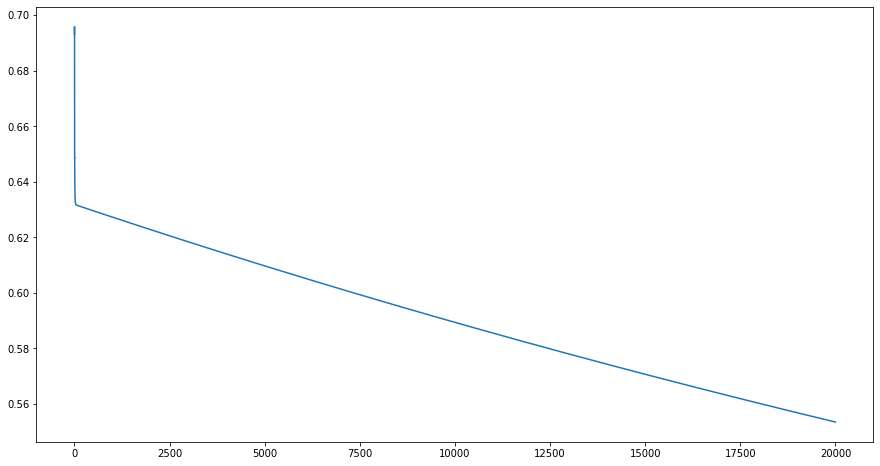

In [15]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(J_history.shape[0]), J_history)
plt.show()

In [16]:
# solo usando molte iter ottengo un risultato accettabile
theta_gd

array([[-1.25055245],
       [ 0.01878497],
       [ 0.01044434]])

In [17]:
#effettuo un addestramento con un numero di iterazioni piccoli
theta_gd, J_history = gradientDescentVectorized(x_train.values, y_train.values, alpha = 0.001 ,num_iters=1000)

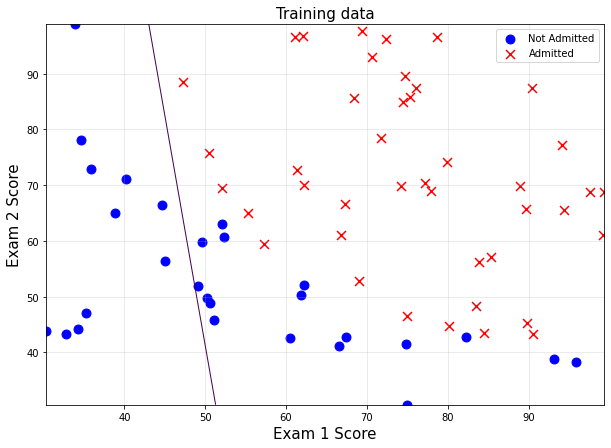

In [18]:
plt.figure(figsize = (10,7)) # dichiaro l'ambiente per disegnare
plt.scatter(train_neg.iloc[:,1],train_neg.iloc[:, 2], marker='o', c='blue', label='Not Admitted', s=80)
plt.scatter(train_pos.iloc[:,1],train_pos.iloc[:, 2], marker='x', c='red', label='Admitted', s=80)

######## calcolo dell'ipotesi ########
x1_min = x_train.iloc[:,1].min();
x1_max = x_train.iloc[:,1].max();

x2_min = x_train.iloc[:,2].min();
x2_max = x_train.iloc[:,2].max();

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

h = np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(theta_gd)

####### fine calcolo ipotesi ########

# countour plot #

plt.contour(xx1, xx2, h.reshape(xx1.shape), [0.5], linewidths=1)

plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Training data', fontsize=15)
plt.show()

In questo grafico vediamo che il gradient descent non tuned fa schido.
Ci siamo dovuti sforzare davvero tanto (almeno 2000000 iters) per ottenere una retta accettabile, passiamo ad usare l'optimizer

# Advanced Optimization

In [19]:
def gradient(theta, x, y):
    
    m = x.shape[0]
    h = sigmoid(x.dot(theta.reshape(-1,1)))
    grad = (1/m)*x.T.dot(h-y)
    
    return (grad.flatten())

In [20]:
res = minimize(costFunctionVectorized, np.zeros((x_train.shape[1],1)), args=(x_train.values, y_train.values), method="BFGS", jac=gradient)

theta_optimizer = res.x.reshape(-1,1)



<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))


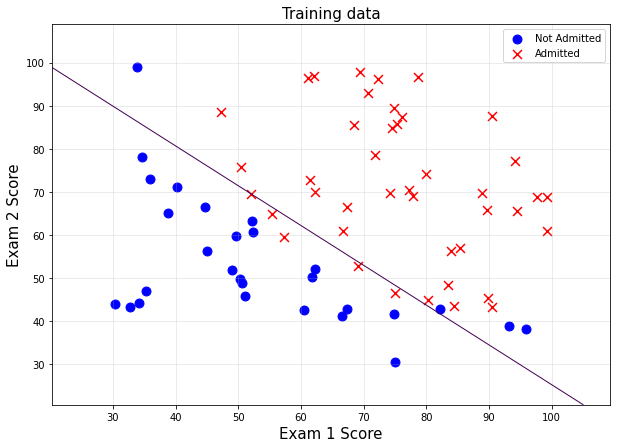

In [21]:
plt.figure(figsize = (10,7)) # dichiaro l'ambiente per disegnare
plt.scatter(train_neg.iloc[:,1],train_neg.iloc[:, 2], marker='o', c='blue', label='Not Admitted', s=80)
plt.scatter(train_pos.iloc[:,1],train_pos.iloc[:, 2], marker='x', c='red', label='Admitted', s=80)

######## calcolo dell'ipotesi ########
x1_min = x_train.iloc[:,1].min() -10;
x1_max = x_train.iloc[:,1].max() +10;

x2_min = x_train.iloc[:,2].min() -10;
x2_max = x_train.iloc[:,2].max() +10;

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

h = np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(theta_optimizer)

####### fine calcolo ipotesi ########

# countour plot #

plt.contour(xx1, xx2, h.reshape(xx1.shape), [0.05], linewidths=1)

plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Training data', fontsize=15)
plt.show()

## Binary Classifier Evaluation

In [22]:
h_train_score = sigmoid(x_train.dot(theta_optimizer))

In [23]:
threshold = 0.5

#yhat_train è il vettore delle predizioni
yhat_train = h_train_score.copy()

yhat_train[yhat_train >= threshold] = 1
yhat_train[yhat_train < threshold] = 0

# Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

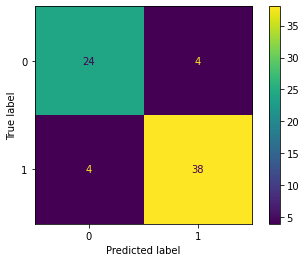

In [25]:
cm = confusion_matrix(y_train, yhat_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, precision_score,\
recall_score, f1_score, roc_curve, roc_auc_score

In [27]:
report = classification_report(y_train, yhat_train)

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.90      0.90      0.90        42

    accuracy                           0.89        70
   macro avg       0.88      0.88      0.88        70
weighted avg       0.89      0.89      0.89        70



## Accuracy

In [29]:
accuracy = np.round(accuracy_score(y_train,yhat_train), 2)

## Precision

In [30]:
precision = np.round(precision_score(y_train,yhat_train), 2)

## Recall

In [31]:
recall = np.round(recall_score(y_train,yhat_train), 2)

## F1-score Plot

In [32]:
f1_score_list = []
#devo ciclare su varie(100) threshold tra 0 e 1

thresholds = np.linspace(0,1,100)
for t in thresholds:
    #yhat_train è il vettore delle predizioni
    yhat_train = h_train_score.copy()

    yhat_train[yhat_train >= t] = 1
    yhat_train[yhat_train < t] = 0
    
    f1_score_list.append(f1_score(y_train, yhat_train))

max_threshold_idx = np.argmax(f1_score_list)

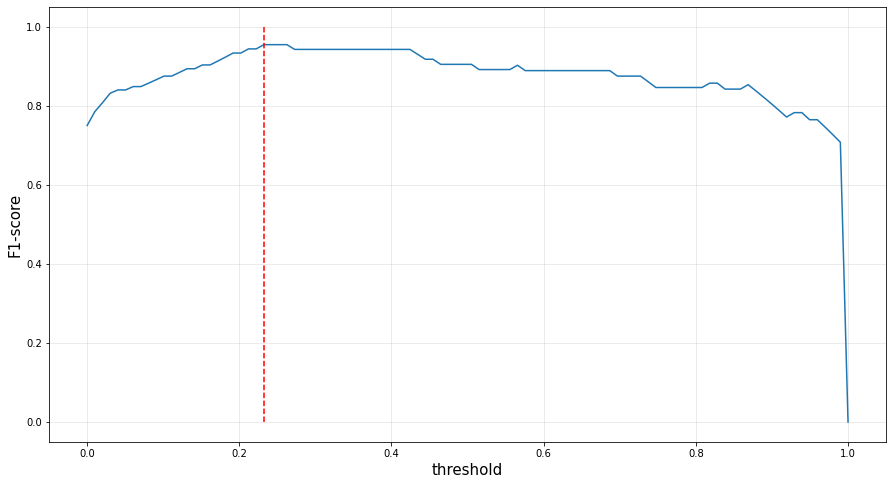

In [33]:
plt.figure(figsize=(15,8))
plt.plot(thresholds, f1_score_list)
plt.vlines(thresholds[max_threshold_idx], 0, 1, colors = 'r', linestyle='dashed' )
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)
plt.grid(alpha = 0.3)
plt.show()

# ROC-AUC curves

In [34]:
fpr, tpr, roc_trs = roc_curve(y_train, h_train_score, drop_intermediate=False)
roc_auc_score = np.round(roc_auc_score(y_train, h_train_score),2)

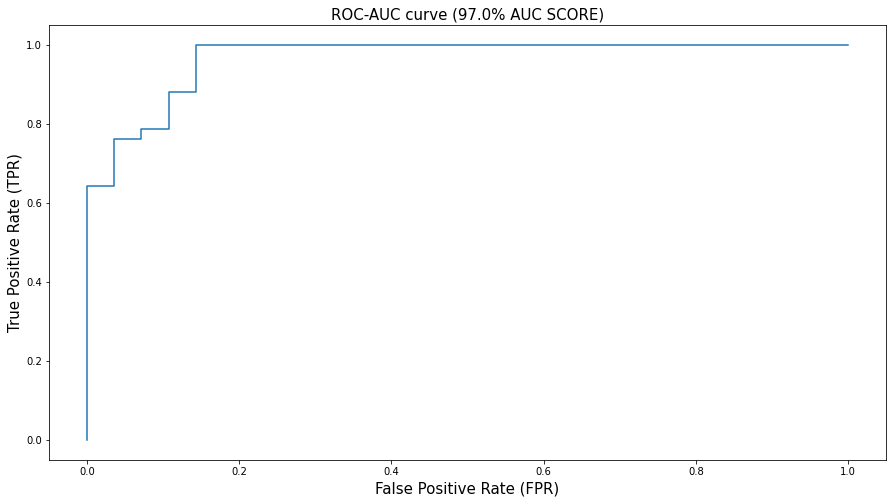

In [35]:
plt.figure(figsize=(15,8))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (FPR)', fontsize=15)
plt.ylabel('True Positive Rate (TPR)', fontsize=15)
plt.title('ROC-AUC curve ({}% AUC SCORE)'.format(roc_auc_score*100), fontsize=15)
plt.show()

# Precision-Recall Curve

In [36]:
from sklearn.metrics import precision_recall_curve,auc

In [37]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_train, h_train_score)
pr_auc = np.round(auc(recalls, precisions),2)

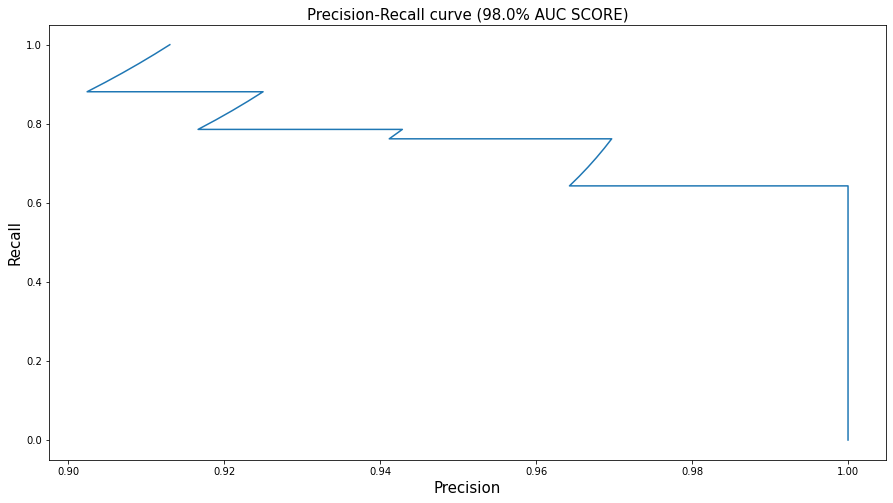

In [38]:
plt.figure(figsize=(15,8))
plt.plot(precisions,recalls)
plt.ylabel('Recall', fontsize=15)
plt.xlabel('Precision', fontsize=15)
plt.title('Precision-Recall curve ({}% AUC SCORE)'.format(pr_auc*100), fontsize=15)
plt.show()

# Inference on test set

In [39]:
# classe negativa
test_neg = x_test[y_test.Result == 0]
# classe positiva
test_pos = x_test[y_test.Result == 1]

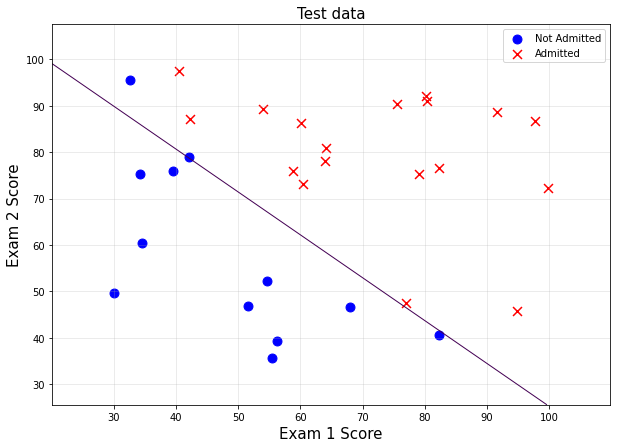

In [40]:
plt.figure(figsize = (10,7)) # dichiaro l'ambiente per disegnare
plt.scatter(test_neg.iloc[:,1],test_neg.iloc[:, 2], marker='o', c='blue', label='Not Admitted', s=80)
plt.scatter(test_pos.iloc[:,1],test_pos.iloc[:, 2], marker='x', c='red', label='Admitted', s=80)

######## calcolo dell'ipotesi ########    +10 e -10 per ragioni grafiche
x1_min_test = x_test.iloc[:,1].min() -10;
x1_max_test = x_test.iloc[:,1].max() +10;

x2_min_test = x_test.iloc[:,2].min() -10;
x2_max_test = x_test.iloc[:,2].max() +10;

xx1_test, xx2_test = np.meshgrid(np.linspace(x1_min_test, x1_max_test), np.linspace(x2_min_test, x2_max_test))

h = np.c_[np.ones((xx1_test.ravel().shape[0],1)), xx1_test.ravel(), xx2_test.ravel()].dot(theta_optimizer)

####### fine calcolo ipotesi ########

# countour plot #

plt.contour(xx1_test, xx2_test, h.reshape(xx1_test.shape), [0.05], linewidths=1)

plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Test data', fontsize=15)
plt.show()

In [41]:
h_test_score = sigmoid(x_test.dot(theta_optimizer))

In [42]:
#threshold = 0.5

#yhat_test è il vettore delle predizioni
yhat_test = h_test_score.copy()

yhat_test[yhat_test >= threshold] = 1
yhat_test[yhat_test < threshold] = 0

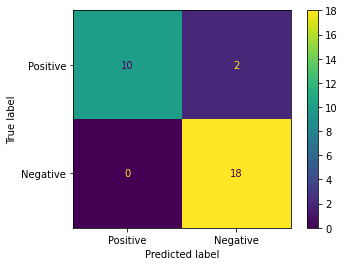

In [43]:
cm_test = confusion_matrix(y_test, yhat_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive','Negative'])
disp_test.plot()
plt.show()

## Metrics

In [44]:
report_test = classification_report(y_test, yhat_test)

In [45]:
print(report_test)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.90      1.00      0.95        18

    accuracy                           0.93        30
   macro avg       0.95      0.92      0.93        30
weighted avg       0.94      0.93      0.93        30



In [64]:
accuracy_test = np.round(accuracy_score(y_test,yhat_test), 2)
precision_test = np.round(precision_score(y_test,yhat_test), 2)
recall_test = np.round(recall_score(y_test,yhat_test), 2)

In [65]:
print('Accuracy:  {}%\nPrecision: {}%\nRecall:    {}%\n'.format(accuracy_test*100, precision_test*100, recall_test*100))

Accuracy:  93.0%
Precision: 90.0%
Recall:    100.0%



# Accuracy paradox

Riferimento al 'Paradox accuracy' che incorre nel caso di dataset sbilanciato.
Se ho tanti 0, la funzione di costo classifica furbescamente quasi tutti 0, incorrendo in un'altissima sccuracy
per via dei pochi 1.
Questo però porterebbe ad un classificatore ciofeca nonostante i grandi numeri di accuracy.

# By Andrea: addestramento con polinomio di grado 2

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly = PolynomialFeatures(2)
XX = poly.fit_transform(x_train.iloc[:,1:3])

In [50]:
from scipy.optimize import minimize


In [51]:
def gradientReg(theta, x, y, reg = 0):
    
    m = x.shape[0]
    h = sigmoid(x.dot(theta.reshape(-1,1)))
    grad = (1/m)*x.T.dot(h-y) + (reg/m)*np.r_[[[0]], theta[1:].reshape(-1,1)]
    
    return (grad.flatten())

In [52]:
def classify(theta, x, threshold = 0.5):
    positive = sigmoid(x.dot(theta)) >= threshold
    return positive.astype('int')

<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
<ipython-input-10-35ba2b304938>:6: RuntimeWarning: divide by zero encountered in log
  J = -1*(1/m)*(np.log(h).T.dot(y) + np

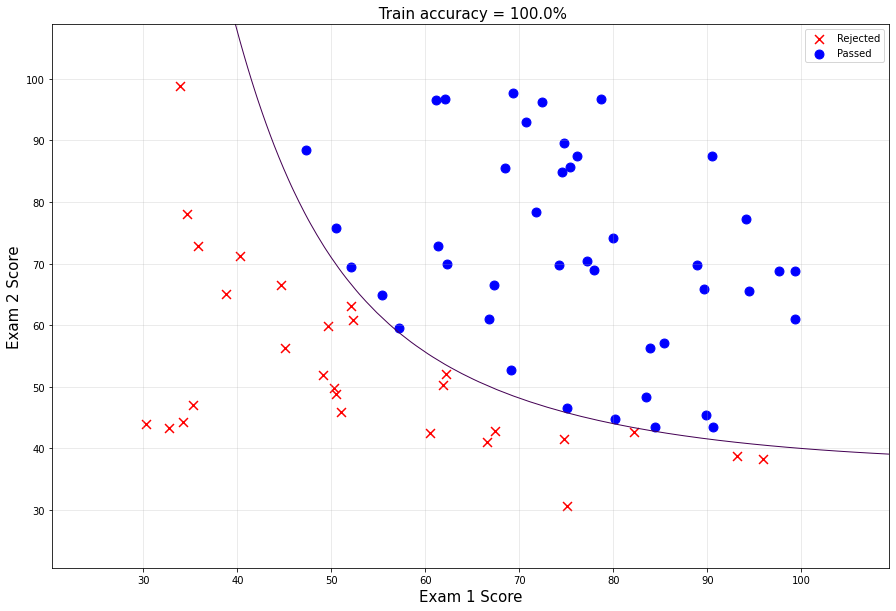

In [53]:
fig = plt.figure(figsize=(15,10))

res = minimize(costFunctionVectorized, np.zeros((XX.shape[1],1)), args=(XX, y_train.values), method="BFGS", jac=gradientReg)
theta_optimizer_quadratic = res.x.reshape(-1,1)
accuracy = (sum(classify(res.x, XX) == y_train.values.ravel())/y_train.shape[0])*100
plt.scatter(train_neg.iloc[:,1],train_neg.iloc[:, 2], marker='x', c='red', label='Rejected', s=80)
plt.scatter(train_pos.iloc[:,1],train_pos.iloc[:, 2], marker='o', c='blue', label='Passed', s=80)

######## calcolo dell'ipotesi ########
x1_min = x_train.iloc[:,1].min() -10;
x1_max = x_train.iloc[:,1].max() +10;

x2_min = x_train.iloc[:,2].min() -10;
x2_max = x_train.iloc[:,2].max() +10;

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

h = poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta_optimizer_quadratic)
####### fine calcolo ipotesi ########

# countour plot #

plt.contour(xx1, xx2, h.reshape(xx1.shape), [0], linewidths=1)

plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.legend()
plt.grid(alpha=0.3)
plt.title(' Train accuracy = {}%'.format(np.round(accuracy,2)), fontsize=15)
plt.show()

In [75]:
h_score_train_quadratic = sigmoid(XX.dot(theta_optimizer_quadratic))
#threshold = 0.5

#yhat_test è il vettore delle predizioni
yhat_train_quadratic = h_score_train_quadratic.copy()

yhat_train_quadratic[yhat_train_quadratic >= threshold] = 1
yhat_train_quadratic[yhat_train_quadratic < threshold] = 0

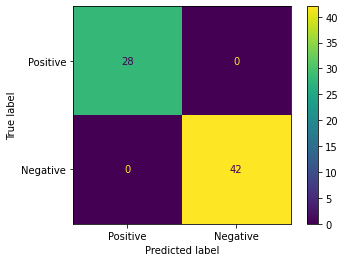

In [76]:
cm_train_quadratic = confusion_matrix(y_train, yhat_train_quadratic)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_train_quadratic, display_labels=['Positive','Negative'])
disp_test.plot()
plt.show()

In [71]:
accuracy_train_quadratic = np.round(accuracy_score(y_train,yhat_train_quadratic), 2)
precision_train_quadratic = np.round(precision_score(y_train,yhat_train_quadratic), 2)
recall_train_quadratic = np.round(recall_score(y_train,yhat_train_quadratic), 2)
print('Accuracy:  {}%\nPrecision: {}%\nRecall:    {}%\n'.format(accuracy_train_quadratic*100, precision_train_quadratic*100, recall_train_quadratic*100))

Accuracy:  100.0%
Precision: 100.0%
Recall:    100.0%



# Inference sul polinomio di grado 2

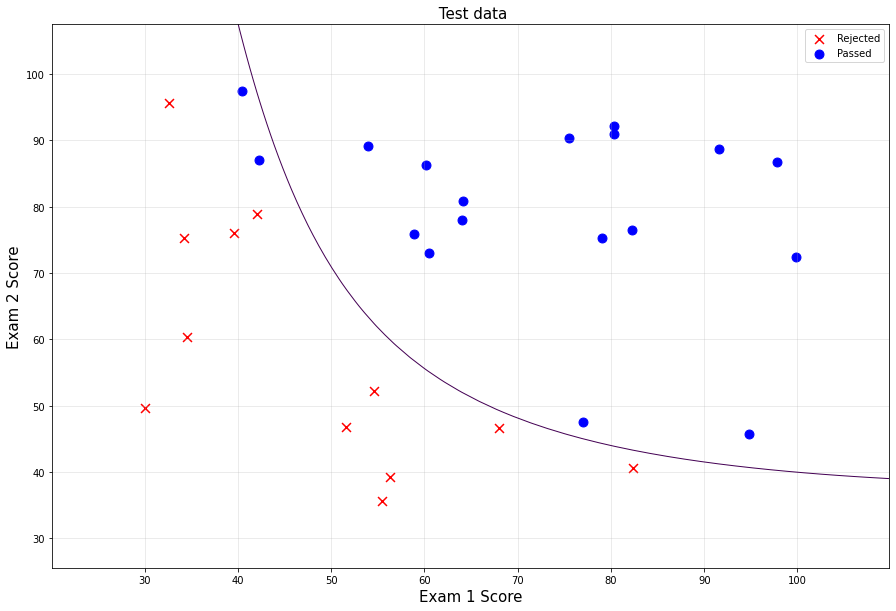

In [73]:
fig = plt.figure(figsize=(15,10))

plt.scatter(test_neg.iloc[:,1],test_neg.iloc[:, 2], marker='x', c='red', label='Rejected', s=80)
plt.scatter(test_pos.iloc[:,1],test_pos.iloc[:, 2], marker='o', c='blue', label='Passed', s=80)

######## calcolo dell'ipotesi ########
x1_min = x_test.iloc[:,1].min() -10;
x1_max = x_test.iloc[:,1].max() +10;

x2_min = x_test.iloc[:,2].min() -10;
x2_max = x_test.iloc[:,2].max() +10;

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

h = poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta_optimizer_quadratic)
####### fine calcolo ipotesi ########

# countour plot #

plt.contour(xx1, xx2, h.reshape(xx1.shape), [0], linewidths=1)

plt.xlabel(columns[0], fontsize=15)
plt.ylabel(columns[1], fontsize=15)
plt.legend()
plt.grid(alpha=0.3)
plt.title(' Test data', fontsize=15)
plt.show()

## Test Metrics

In [77]:
XX_test = poly.fit_transform(x_test.iloc[:,1:3])

In [79]:
h_test_score_quadratic = sigmoid(XX_test.dot(theta_optimizer_quadratic))

In [80]:
#threshold = 0.5

#yhat_test è il vettore delle predizioni
yhat_test_quadratic = h_test_score_quadratic.copy()

yhat_test_quadratic[yhat_test_quadratic >= threshold] = 1
yhat_test_quadratic[yhat_test_quadratic < threshold] = 0

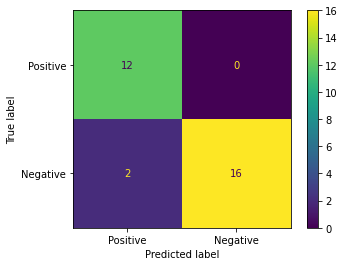

In [81]:
cm_test_quadratic = confusion_matrix(y_test, yhat_test_quadratic)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_quadratic, display_labels=['Positive','Negative'])
disp_test.plot()
plt.show()

In [84]:
accuracy_test_quadratic = np.round(accuracy_score(y_test,yhat_test_quadratic), 2)
precision_test_quadratic = np.round(precision_score(y_test,yhat_test_quadratic), 2)
recall_test_quadratic = np.round(recall_score(y_test,yhat_test_quadratic), 2)

In [85]:


print('Accuracy:  {}%\nPrecision: {}%\nRecall:    {}%\n'.format(accuracy_test_quadratic*100, precision_test_quadratic*100, recall_test_quadratic*100))



Accuracy:  93.0%
Precision: 100.0%
Recall:    89.0%

